In [1]:
import os
import numpy as np
import matplotlib.pyplot as plt
import xarray as xr

import pandas as pd
import seaborn as sns

In [2]:
import graphufs
plt.style.use("graphufs.plotstyle")

In [3]:
fig_dir = "figures"
if not os.path.isdir(fig_dir):
    os.makedirs(fig_dir)

In [5]:
models = [
    #"GraphUFS p1",
    "GraphUFS p2",
    "GraphUFS p2p uvwc",
    #"GraphUFS p2p uvwcsic",
    #"GraphUFS p2p uvwcsicisp",
    #"GraphUFS p2p uvnc",
    #"GraphUFS p2p uvncbs32",
    #"GraphUFS p2p nvnc",
    "Replay",
    "GraphCast",
]


In [11]:
duration = "240h"
year = 2018

data_dir = "/Projects/ml_benchmarks"

spectra = {}

for model in models:
    name = model.lower().split(" ")[0]
    if "GraphUFS" in model:
        location = f"{data_dir}/{model.replace(' ', '/').lower()}/validation"
        middle = duration
    elif "Replay" in model:
        middle = "vertical_regrid"
        location = f"{data_dir}/graphufs/p2/validation"
    else:
        middle = year
        location = f"{data_dir}/baselines"

    path = f"{location}/{name}.{middle}.spectra.zarr"
    newname = "model" if model != "GraphUFS p2p uvwc" else "GraphUFS p2c"
    spectra[model] = graphufs.utils.open_zarr(path)

## Spectra

In [12]:
def get_save_kwargs(fhr, use_seaborn, show_diff, zoom):
    fname = f"{fig_dir}/spectra_surface_{fhr:03d}h"
    if zoom: 
        fname += "_zoom"
    if use_seaborn:
        fname += "_ci"
    if show_diff:
        fname + "_diff"
    fname += ".jpeg"
    return {"fname": fname, "bbox_inches": "tight", "dpi": 300}

In [13]:
def plot_spectra(
    mds,
    fhr,
    fields=("2m_temperature", "10m_u_component_of_wind", "10m_v_component_of_wind"),
    use_seaborn=False,
    show_diff=False,
    zoom=False,
    save=False,
):
    ncols = len(fields)
    fig, axs = plt.subplots(1, ncols, figsize=(ncols*4, 4), constrained_layout=True)

    for i, (fld, ax) in enumerate(zip(fields, axs)):
        
        for j, (label, xds) in enumerate(mds.items()):
            kw = {
                "ax": ax,
                "x": "zonal_wavenumber",
                "color": f"C{j}" if label != "Replay" else "gray",
                "label": label if i == 0 else None,
                "linewidth": 2,
            }
            if (show_diff and label != "Replay") or not show_diff:
                if fld in xds:
                    plotme = xds[fld]
                    if "fhr" in plotme.dims:
                        plotme = plotme.sel(fhr=fhr)
                    if show_diff:
                        plotme = plotme - mds["Replay"][fld]
                        plotme = np.abs(plotme)
                        plotme /= np.abs(mds["Replay"][fld])
                    if use_seaborn:
                        sns.lineplot(
                            data=plotme.to_dataframe().reset_index(),
                            y=fld,
                            legend=False,
                            **kw,
                        )
                    else:
                        plotme.mean("latitude").plot(add_legend=False, **kw)
        title = " ".join([x.capitalize() if x != "of" else x for x in fld.replace("_", " ").split(" ")])
        zkw = {}
        if zoom:
            zkw = {"ylim": [None, 1e6], "xlim": [1e1, None]}
        else:
            if fld == "2m_temperature":
                zkw = {"ylim": [None, 1e9]}
        ax.set(
            xlabel="Zonal Wavenumber",
            ylabel="",
            title=title,
            xscale="log",
            yscale="log",
            **zkw,
        )
        for key in ["right", "top"]:
            ax.spines[key].set_visible(False)

    fig.legend(title=f"Lead Time = {fhr} hours", loc="center left", bbox_to_anchor=(1, .5))
    if save:
        fig.savefig(**get_save_kwargs(fhr=fhr, use_seaborn=use_seaborn, show_diff=show_diff, zoom=zoom))
    return fig, axs

In [14]:
kw = {
    "show_diff": False,
    "use_seaborn": False,
    "zoom": False,
    "save": False,
}

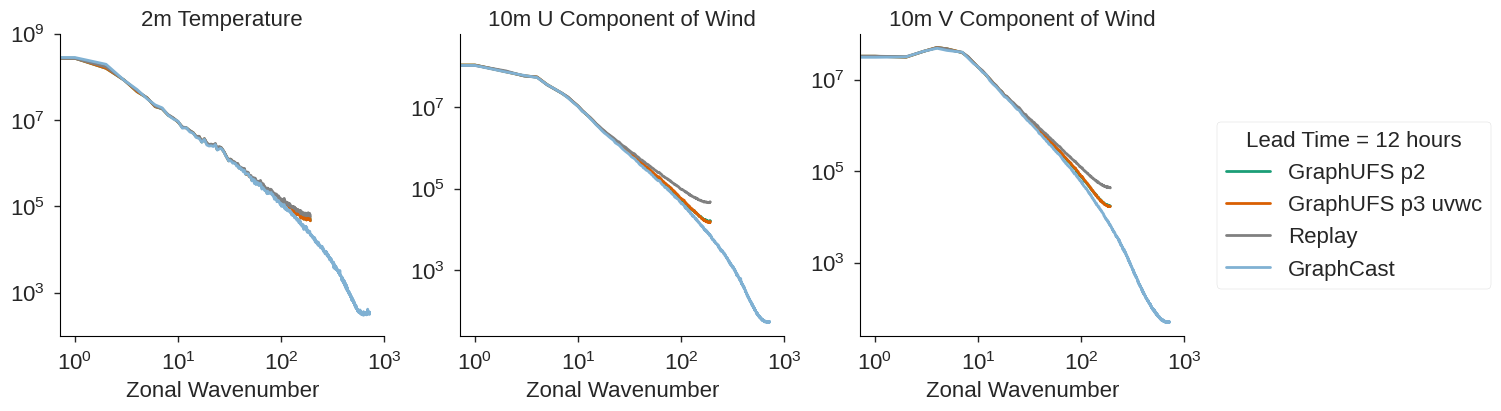

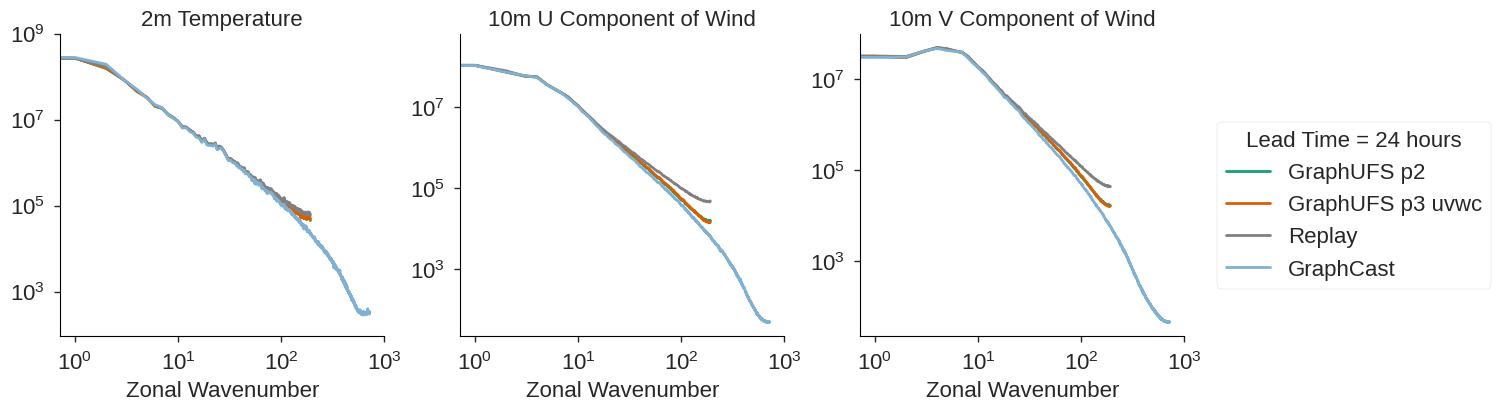

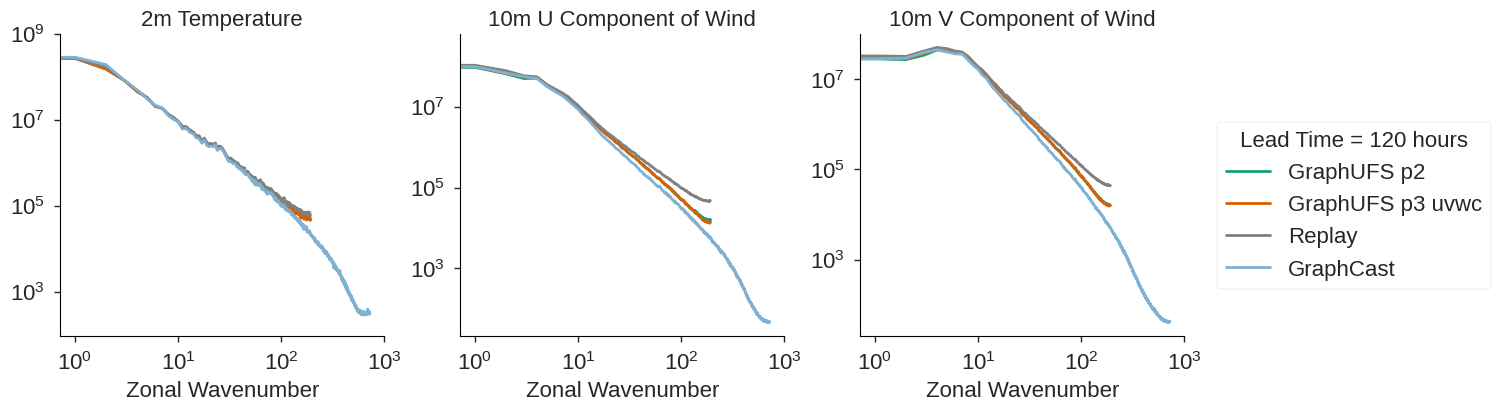

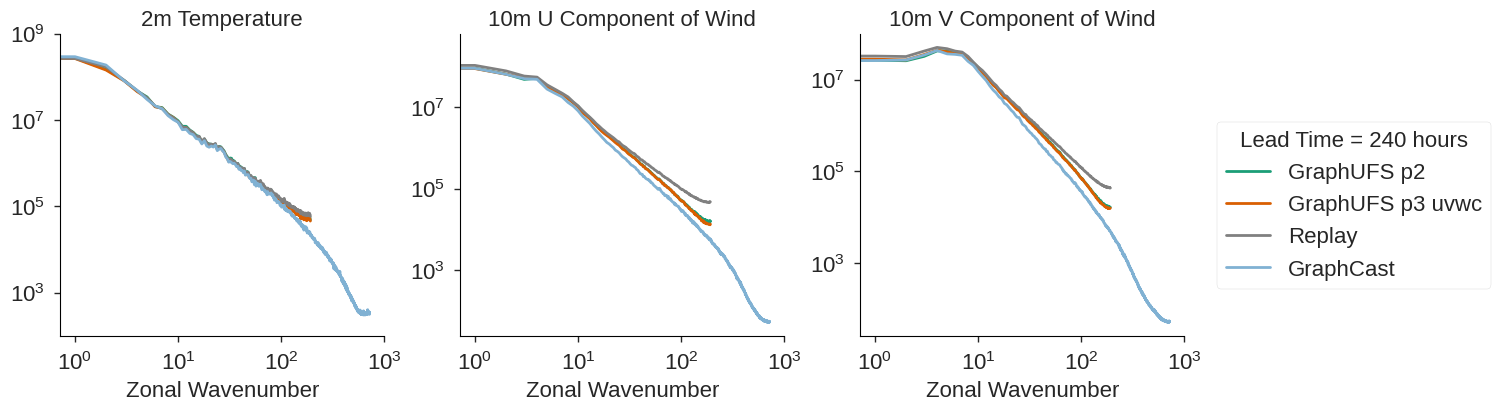

In [15]:
for fhr in [12, 24, 120, 240]:
    fig, axs = plot_spectra(spectra, fhr=fhr, **kw)

In [16]:
kw["zoom"] = True

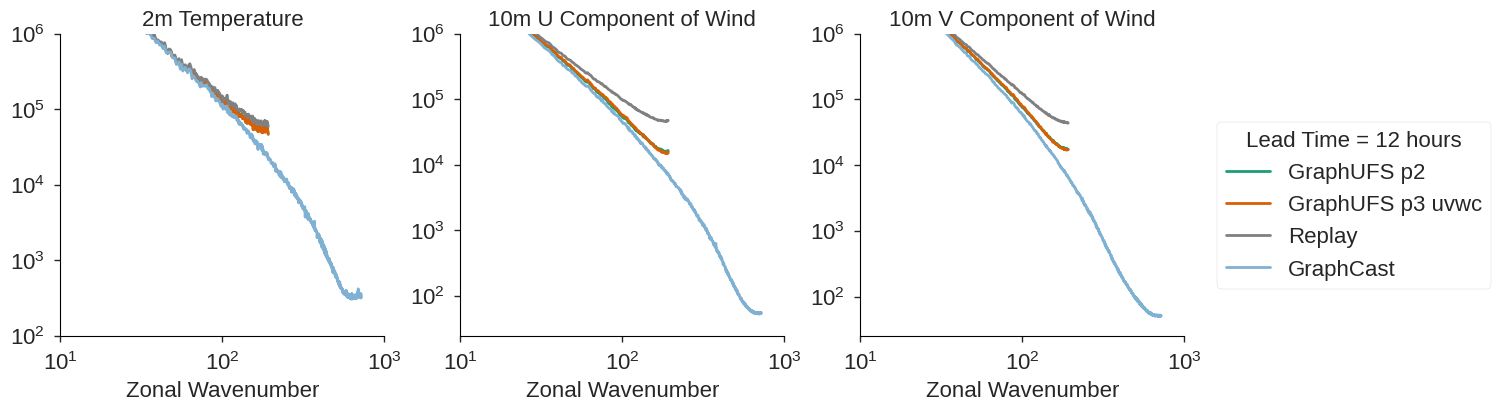

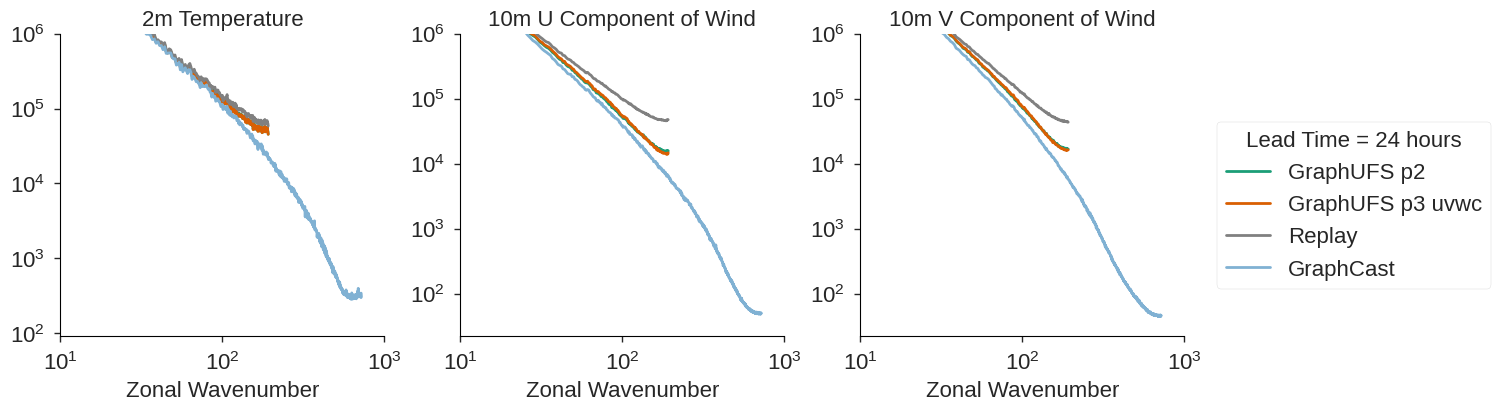

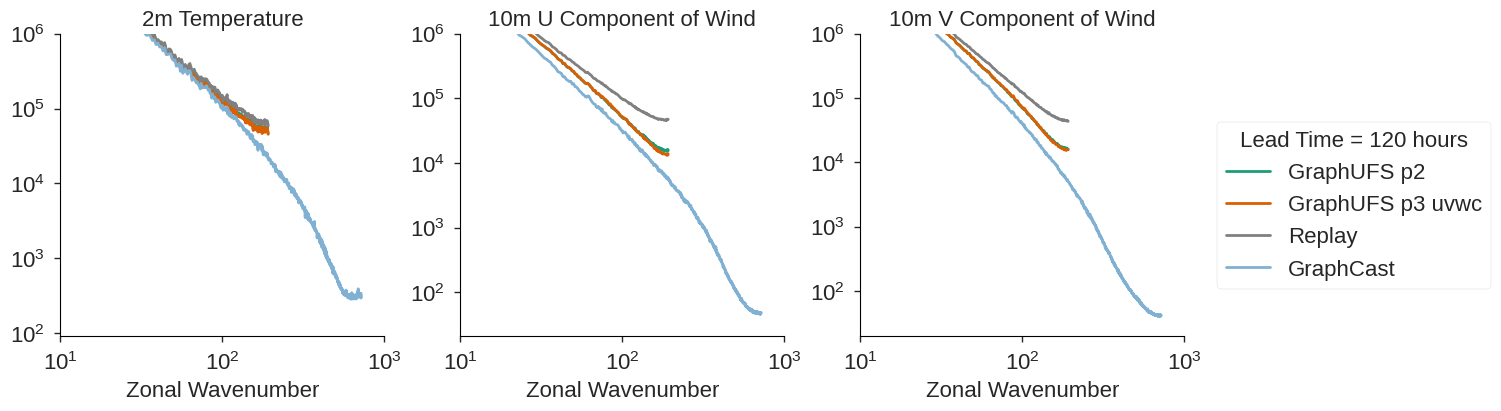

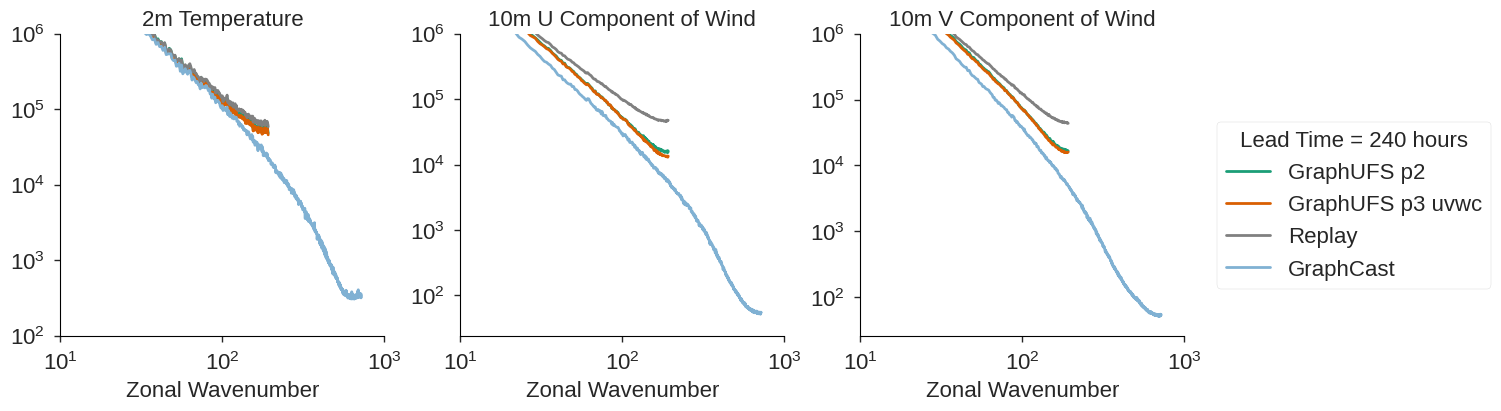

In [17]:
for fhr in [12, 24, 120, 240]:
    fig, axs = plot_spectra(spectra, fhr=fhr, **kw)

Text(0.5, 0.98, 'U Component of Wind')

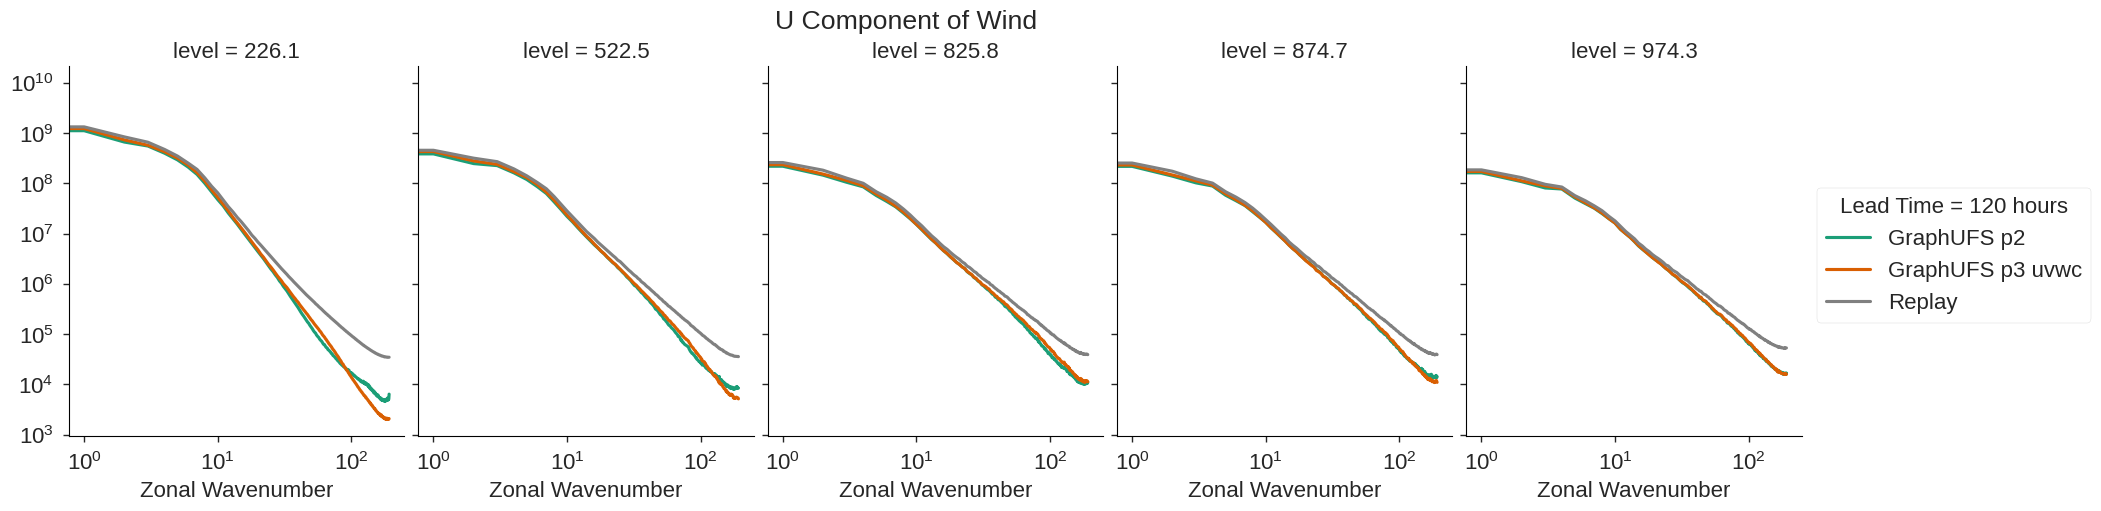

In [18]:
fhr = 120 
fldname = "u_component_of_wind"
fig, axs = plt.subplots(1, 5, figsize=(18,5), constrained_layout=True, sharey=True)
keylist = [key for key in spectra.keys() if key != "GraphCast"]
for key in keylist:
    plotme = spectra[key][fldname]
    if "fhr" in plotme.dims:
        plotme = plotme.sel(fhr=fhr)
    plotme = plotme.mean("latitude")
    for level, ax  in zip(plotme.level.values, axs):
        plotme.sel(level=level).plot(
            ax=ax,
            yscale="log",
            xscale="log",
            color="gray" if key == "Replay" else None,
            label=key if ax.get_subplotspec().is_first_col() else None,
        )
        ax.set(xlabel="Zonal Wavenumber", ylabel="")

fig.legend(title=f"Lead Time = {fhr} hours", loc="center left", bbox_to_anchor=(1, .5))
fig.suptitle(" ".join([x.capitalize() if x != "of" else x for x in fldname.split("_")]))

Text(0.5, 0.98, 'Specific Humidity Top Level')

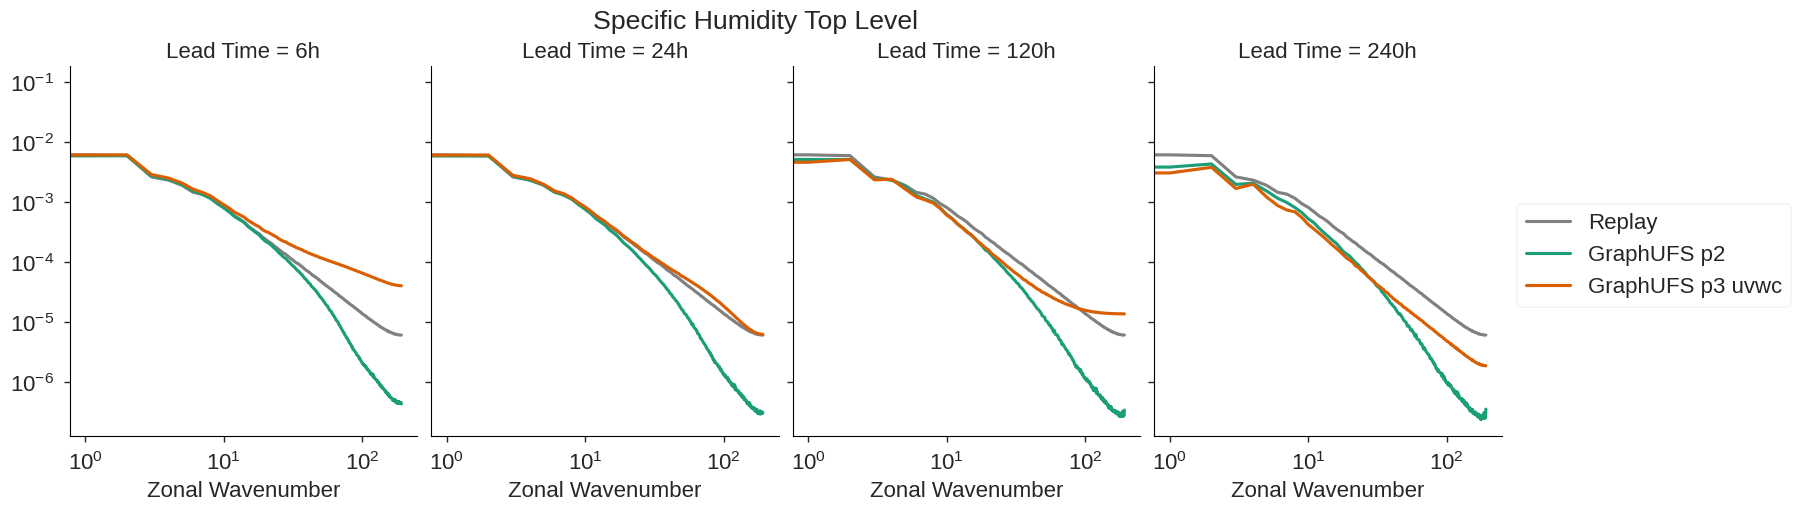

In [19]:
fldname = "specific_humidity"
fhrs = [6, 24, 120, 240]
fig, axs = plt.subplots(1, 4, figsize=(15,5), constrained_layout=True, sharey=True)
keylist = [key for key in spectra.keys() if key != "GraphCast" and key != "Replay"]

for ax in axs:
    plotme = spectra["Replay"][fldname].sel(level=226,method='nearest').mean("latitude")
    plotme.plot(ax=ax, color="Gray", label="Replay" if ax.get_subplotspec().is_first_col() else None)
    ax.set(ylabel="", title="")
    
for key in keylist:
    plotme = spectra[key][fldname]
    plotme = plotme.sel(level=226, method="nearest")
    plotme = plotme.mean("latitude")
    for fhr, ax in zip(fhrs, axs):
        plotme.sel(fhr=fhr).plot(
            ax=ax,
            yscale="log",
            xscale="log",
            label=key if ax.get_subplotspec().is_first_col() else None,
        )

for fhr, ax in zip(fhrs, axs):
    ax.set(xlabel="Zonal Wavenumber", ylabel="", title=f"Lead Time = {fhr}h")

fig.legend(loc="center left", bbox_to_anchor=(1, .5))
fig.suptitle(" ".join([x.capitalize() if x != "of" else x for x in fldname.split("_")])+ " Top Level")